# Week 3: CNN Cancer Detection Kaggle Mini-Projec
2023.10.14 D.Ikoma
## 1. Brief description of the problem and data 

In this project, we create CNN models to identify metastatic cancer in small image patches taken from larger digital pathology scans [1-2]. The data is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset[3].

In this dataset, we are provided with a large number of small pathology images to classify. Data files are named with an image `id`. The train_labels.csv file provides the ground truth for the images in the train folder. We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

### Import libraries

In [1]:
# import libraries
from glob import glob 
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

import gc #garbage collection, we need to save all the RAM we can

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read dataset

In [2]:
# set paths to training and test data
path = "../input/histopathologic-cancer-detection/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [4]:
df.shape

(220025, 3)

The data contains the ID and label of 220025 files. `id` is the file name of the image tif file, and `label=1` indicates that the image contains cancer.

In [5]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

print("train data size: ", round(get_dir_size(train_path) / 1e9, 2), "GB")
print("test data size: ", round(get_dir_size(test_path) / 1e9, 2), "GB")

train data size:  6.15 GB
test data size:  1.61 GB


## 2. Exploratory Data Analysis (EDA)

First, we will check the number of samples of negative data without cancer and positive data.

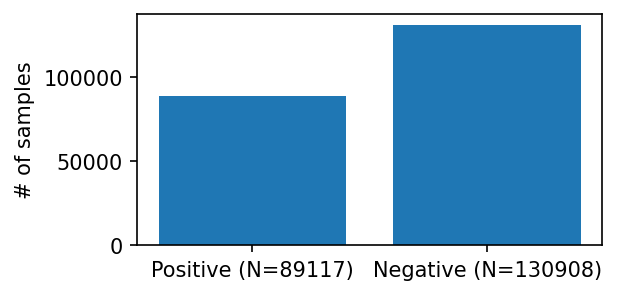

In [6]:
#plot a bar chart of the label frequency
fig = plt.figure(figsize=(4, 2), dpi=150)
plt.bar([1,0], [(labels['label']==0).sum(), (labels['label']==1).sum()]);
plt.xticks([1,0],["Negative (N={})".format((labels['label']==0).sum()),"Positive (N={})".format((labels['label']==1).sum())]);
plt.ylabel("# of samples")
plt.show()

Negative data without cancer (N=130,908) has a larger number of samples than positive data (N=89,117), but since it is not extremely imbalanced, over/under sampling is not considered necessary.

Next, we will look at the some images.

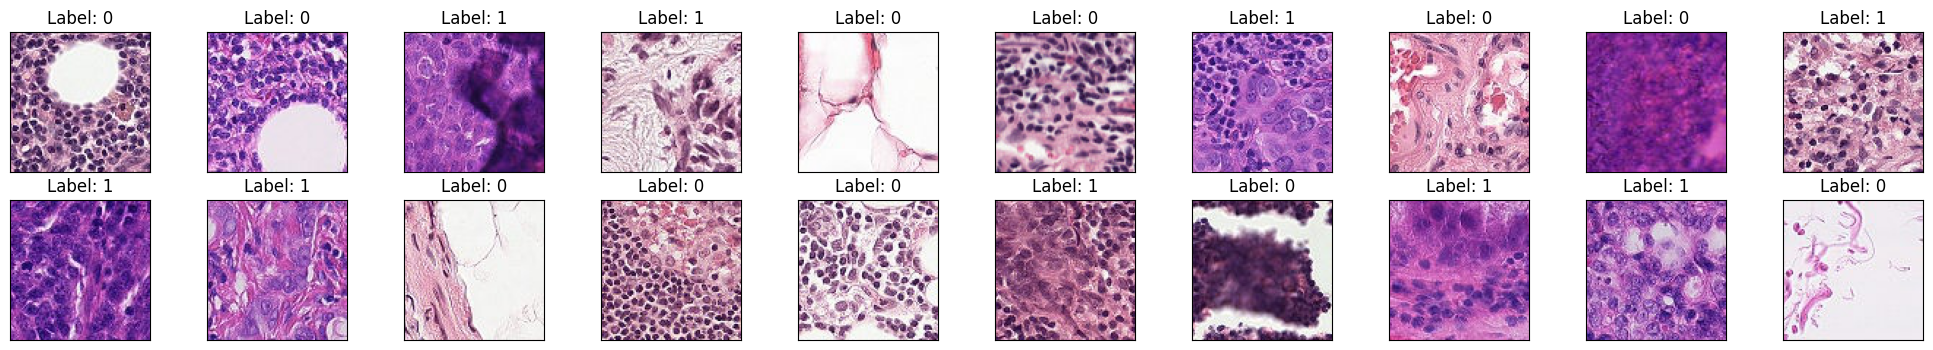

In [7]:
# display 20 images
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/train/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

Now, we will load some of the images. As interactive kernels with GPU currently offer about 14 GB of RAM, we will take care to keep the images in the uint8 format (i.e. pixel values are integers between 0 and 255) to reduce the memory footprint. Processing of the images often requires converting them to float32, which would require additional space.

We'll declare a function to load a set number of images and then load 10000 images.

In [3]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df['label'].values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [4]:
# Load 1k images
N=1000
X,y = load_data(N=N,df=df) 

100%|██████████| 1000/1000 [00:19<00:00, 50.47it/s]


We'll now split the data into positive and negative samples to get an idea what makes the classes unique. Such an analysis can often provide insight into possible feature engineering possibilities or which data transformations may be useful.

In [10]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Now, we will compare the distribution of pixel values for each color channel (RGB) individually and all channels together

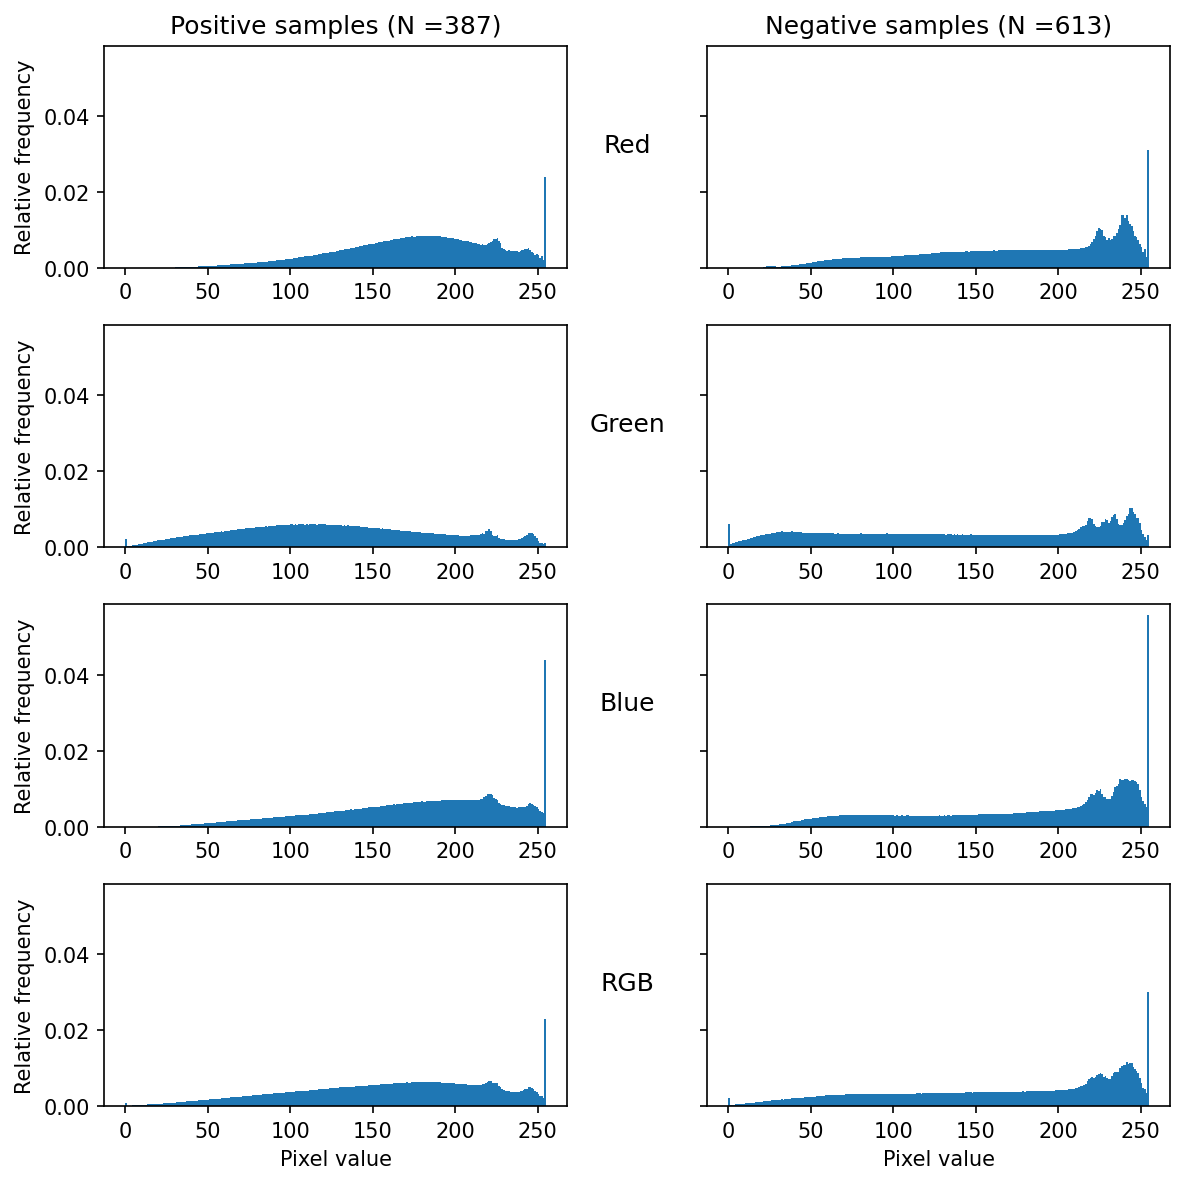

In [11]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

We check the differences in the distribution of all channels between positive and negative samples individually or together. Negative samples generally appear to have higher, or brighter, pixel values. The dark pixels in both sample sets are almost exclusively present in the green channel. Furthermore, we can see that the frequency of pixel value 255 is relatively high. Looking at the image data, we see that these may be due to bright white image areas present in some images. They appear to be equally frequent in both positive and negative samples. Now let's switch perspective and look at the average brightness of the image, or the distribution of the image's average pixel values.

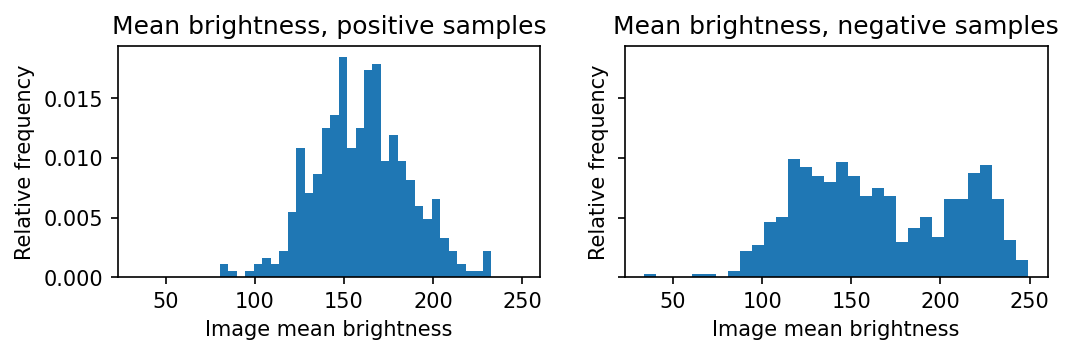

In [12]:
nr_of_bins = 32 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

The distribution of the average brightness of the positive samples looks like a normal distribution around brightness 160. However, the negative samples appear to follow a bimodal distribution with peaks around 140 and 225. In summary, there are some easily spotted differences in the distributions of pixel values and mean image brightness between positive and negative samples.

## 3. Model Architecture

### Setup
We will now focus on creating a simple model for this problem. The data is relatively well balanced and accesible. Let's start by loading all the data, not just a subset as before. This will likely require a few minutes. However, we only need to do it once.

In [13]:
N = 100000
X,y = load_data(N=N,df=df)

100%|██████████| 100000/100000 [12:42<00:00, 131.17it/s]


We will use the garbage collector and unbind some variables to free up space in our RAM.

In [14]:
# collect garbage
positives_samples = None
negative_samples = None
gc.collect();

Now, we will split the data into a training and validation set. We will use 80% of the data for training and 20% to validate that our model can generalize to new data. After that, to avoid any influence of a possible previous sorting of data we will shuffle the data in-place.

In [5]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

We will declare our neural network architecture now. This kernel uses keras, which makes it very easy to setup a neural network and start training it. It is a relatively simple convolutional neural network with three blocks of convolutional layers, batch normalization, pooling and dropout.

In [6]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

We will use a batch size of 50, binary crossentropy as loss function and the Adam optimizer. We set the learning rate of 0.001. As output we will get the classification accuracy of the model.

In [17]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

We are now ready to start training our model.

## 4. Results and Analysis
### Train and validate the model
We will now train the model for three epochs. That means the model will have performed a forward and backward pass for each image in the training exactly three times.

In [7]:
def model_train(model):
    #normally you would want to reshuffle the data between epochs, we don't as we split in-place into training/validation
    epochs = 3 #how many epochs we want to perform
    for epoch in range(epochs):
        #compute how many batches we'll need
        iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
        loss,acc = 0,0 #we will compute running loss and accuracy
        with trange(iterations) as t: #display a progress bar
            for i in t:
                start_idx = i * batch_size #starting index of the current batch
                x_batch = X[start_idx:start_idx+batch_size] #the current batch
                y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

                metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

                loss = loss + metrics[0] #compute running loss
                acc = acc + metrics[1] #compute running accuracy
                t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
                t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics

In [19]:
model_train(model)

Running training epoch 2: 100%|██████████| 1600/1600 [01:44<00:00, 15.38it/s, acc=0.88, loss=0.29]


Now, we will perform the accuracy on the validation set without further training the network.

In [8]:
def model_valid(model):
    #compute how many batches we'll need
    iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) #as above, not perfect
    loss,acc = 0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics = model.test_on_batch(x_batch, y_batch) #compute metric results for this batch using the model

            loss = loss + metrics[0] #compute running loss
            acc = acc + metrics[1] #compute running accuracy
            t.set_description('Running training') #set progressbar title
            t.set_description('Running validation')
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))

    print("Validation loss:",loss / iterations)
    print("Validation accuracy:",acc / iterations)

In [21]:
model_valid(model)

Running validation: 100%|██████████| 400/400 [00:09<00:00, 43.74it/s, acc=0.85, loss=0.37]

Validation loss: 0.37320873867720367
Validation accuracy: 0.8465999945998192


### Different architectures
Here, we will examine the effect of accuracy degradation when changing the architecture and reducing the number of conv blocks.

**Model 2**

In [22]:
# Model 2
#initialize the model
model2 = Sequential()

#now add layers to it

#conv block 1
model2.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

#conv block 2
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model2.add(Dense(1, activation = "sigmoid"))

In [23]:
batch_size = 50

model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

In [24]:
model_train(model2)

Running training epoch 2: 100%|██████████| 1600/1600 [01:34<00:00, 16.95it/s, acc=0.88, loss=0.30]


In [25]:
model_valid(model2)

Running validation: 100%|██████████| 400/400 [00:08<00:00, 46.01it/s, acc=0.66, loss=1.03]

Validation loss: 1.029145479425788
Validation accuracy: 0.6566000024229288


**Model 3**

In [26]:
# Model 3
#initialize the model
model3 = Sequential()

#now add layers to it

#conv block 1
model3.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(first_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model3.add(Flatten())
model3.add(Dense(256, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model3.add(Dense(1, activation = "sigmoid"))

In [27]:
batch_size = 50

model3.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

In [28]:
model_train(model3)

Running training epoch 2: 100%|██████████| 1600/1600 [01:12<00:00, 22.01it/s, acc=0.87, loss=0.32]


In [29]:
model_valid(model3)

Running validation: 100%|██████████| 400/400 [00:08<00:00, 48.29it/s, acc=0.79, loss=0.46]

Validation loss: 0.460380472317338
Validation accuracy: 0.7868999974429607


**Summary of different architectures**  
The train accuracy, train loss, validation accuracy, and validation loss of each model are summarized below.

| model | # of conv blocks | train accuracy | train loss | validation accuracy | validation loss |
| :---: | :---: | :---: | :---: | :---: | :---: |
| model | 3 | 0.88 | 0.29 | 0.85 | 0.37 |
| model2 | 2 | 0.88 | 0.30 | 0.66 | 1.03 |
| model3 | 1 | 0.87 | 0.32 | 0.79 | 0.46 |

As expected, the model with 3 convolution bocks had the highest validation accuracy and the lowest loss. On the other hand, for the training data, there was no significant difference in performance between the three models. It can be seen that model has the highest accuracy in terms of generalization performance. We believe that there is room for further improvement in model accuracy by tuning hyperparameters. Considering the calculation time, we set epoch=3, but we believe that increasing the number of epochs is also effective.

### Hyperparameter tuning
Here, we will tune the learning rate, which is an important hyperparameter. In the first model, compare the accuracy when laerning rate is set to 0.0001, 0.001, and 0.01. In the previous section, we learned with learning rate = 0.001, so next we will experiment with learning rate = 0.0001.

In [30]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])

In [31]:
model_train(model)

Running training epoch 2: 100%|██████████| 1600/1600 [01:45<00:00, 15.14it/s, acc=0.91, loss=0.22]


In [32]:
model_valid(model)

Running validation: 100%|██████████| 400/400 [00:09<00:00, 40.43it/s, acc=0.93, loss=0.19]

Validation loss: 0.18912652228027582
Validation accuracy: 0.9297499963641167


Next, we will try learning rate = 0.01.

In [33]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.01), 
              metrics=['accuracy'])

In [34]:
model_train(model)

Running training epoch 2: 100%|██████████| 1600/1600 [01:44<00:00, 15.34it/s, acc=0.89, loss=0.28]


In [35]:
model_valid(model)

Running validation: 100%|██████████| 400/400 [00:09<00:00, 43.59it/s, acc=0.72, loss=1.05]

Validation loss: 1.0533186247944832
Validation accuracy: 0.7212000021338463


Accuracy and loss are summarized below. The best validation accuracy and loss is learning rate=0.0001. Therefore, at learning rate =0.01, 0.001, there is a possibility that the optimal solution is exceeded.

| learning rate | train accuracy | train loss | validation accuracy | validation loss |
| :---: | :---: | :---: | :---: | :---: |
| 0.01 | 0.89 | 0.28 | 0.72 | 1.05 |
| 0.001 | 0.88 | 0.29 | 0.85 | 0.37 |
| 0.0001 | 0.91 | 0.22 | 0.93 | 0.19 |

### Create a submission
Well, now that we have a trained a model, we can create a submission by predicting the labels of the test data and see, where we are at in the leaderboards. The model used is the model with the highest validation accuracy in the preliminary study, which has three convolutional blocks and a learning rate of 0.0001.

In [9]:
N = 150000 #df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

 66%|██████▋   | 99610/150000 [39:32<13:22, 62.82it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 150000/150000 [56:51<00:00, 43.96it/s]


In [10]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [11]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])

model_train(model)
model_valid(model)

Running validation: 100%|██████████| 600/600 [00:11<00:00, 52.78it/s, acc=0.85, loss=0.36]

Validation loss: 0.35824462411304314
Validation accuracy: 0.8457999949653944


In [12]:
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
157/157 [==============================] - 1s 5ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 1s 4ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 1s 4ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 1s 4ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 1s 4ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 1s 4ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 1s 4ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 1s 4ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 1s 5ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 1s 4ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 1s 4ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 1s 6ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.129713
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.187664
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.510939
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.348347
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.686743


In [17]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file
pd.read_csv("submission.csv")

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.129713
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.187664
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.510939
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.348347
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.686743
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0.212311
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0.257043
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0.956400
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0.010258


**Submission result**  
**Score: 0.9151, Public score: 0.9478**

### Confusion Matrix
This time, we will confirm the confusion matrix used to evaluate the model. Since we do not know the correct labels for the test data, we use the training data to check the trends.

4688/4688 [==============================] - 19s 4ms/step


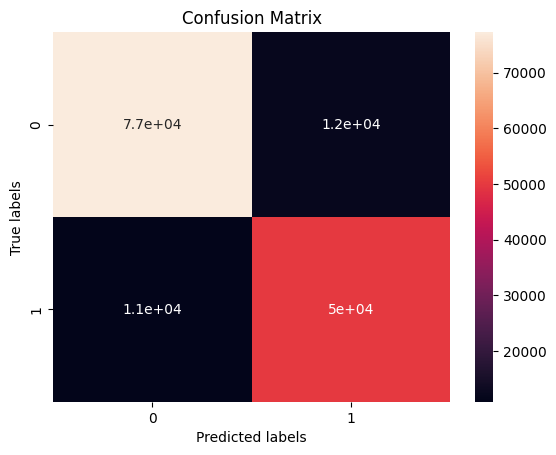

In [16]:
# make a prediction
y_pred_keras = model.predict(X, verbose=1)
y_pred_binary = (y_pred_keras > 0.5).astype(int)

cm = confusion_matrix(y, y_pred_binary)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

The correct answer is 1, predicted is 0, and there are many mistakes. This is an example of an image in which cancer cells are determined not to be present, which is a problem when considering medical applications, and further improvement of the model is required.

## 5. Conclusion

In this project, we created CNN models to identify metastatic cancer in small image patches taken from larger digital pathology scans. We verified the CNN model using the keras library. As a verification point of view, we confirmed the influence of the model architecture, that is, the dependence on the number of convolutional blocks, and the dependence on the hyperparameter, that is, the learning rate. The best model in the scope of study achieved Score: 0.8839, Public score: 0.8123. Further performance improvements are needed, which may include improving hardware such as the TPU and increasing model epochs.


## References

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

[3] Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection